In [3]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.JiT import JiTUncond_B_8
from collections import OrderedDict
import numpy as np

torch.manual_seed(159753)
np.random.seed(159753)

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn

device = 'cuda:1' 
dataset = torch.load(f"data/eit-circles-dtn-default-128.pt", map_location="cpu")
dataset_train = dataset["train"]["dtn_map"]

data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
img_size = 128
original_size = 128
pad_size = 0


mat_fname  = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

background = dtn_from_sigma(sigma_vec=torch.ones(128, 128), v_h=v_h, mesh=mesh, img_size=128, device=device)

dataset_train /= background

train_min = dataset_train.min()
train_max = dataset_train.max()

cwd = /home/johnma/flow-inverse


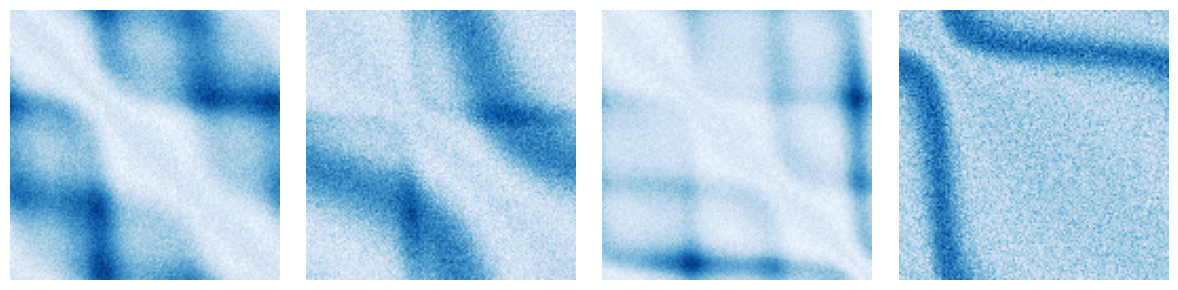

In [34]:
model = JiTUncond_B_8(in_channels=1, input_size=128).to(device)
checkpoint = torch.load("saved_runs/circles-eit-x-pred-dtn-JiT/checkpoints/ckp_100125.tar", map_location=device)
ema_model = AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(0.999))
ema_model.load_state_dict(checkpoint["ema_state_dict"])  # handles n_averaged + module.* keys
model.load_state_dict(ema_model.module.state_dict())     # now matches JiTUncond_B_8
model.eval()
x0 = torch.randn(4, 1, 128, 128).to(device)
def v_from_x_pred(z, t):
    t_batch = t.expand(z.shape[0])
    eval_model = ema_model.module
    return (eval_model(z, t_batch) - z) / torch.clip((1 - t_batch)[:, None, None, None], min=5e-2)
timesteps = torch.linspace(0.0, 1.0, steps=22).to(device)
with torch.no_grad():
    pred = odeint(
    func = lambda t, x: v_from_x_pred(x, t),
    t = timesteps,
    y0 = x0,
    method = 'heun3',
)[-1]

# Unnormalize predictions
pred = 0.5 * (pred + 1.0) * (train_max - train_min) + train_min

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    img = pred[i].squeeze().cpu().numpy()
    axes[i].imshow(img, cmap="Blues")
    axes[i].axis("off")


plt.tight_layout()
plt.show()